In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# NN implementation
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(NN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim

        layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# KAN layer  
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# State-Space Model Implementation
class StateSpaceModel(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kan_layers):
        super(StateSpaceModel, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Define the KANs for state transition and observation
        self.kan_state_transition = KAN([state_dim + input_dim] + kan_layers + [state_dim])
        self.kan_observation = KAN([state_dim + input_dim] + kan_layers + [output_dim])

    def forward(self, state, input, update_grid=False):
        # State transition: x_{t+1} = f(x_t, u_t)
        state_input = torch.cat([state, input], dim=-1)
        next_state = self.kan_state_transition(state_input, update_grid=update_grid)

        # Observation: y_t = g(x_t, u_t)
        observation = self.kan_observation(state_input, update_grid=update_grid)

        return next_state, observation

# Example Usage
state_dim = 4
input_dim = 2
output_dim = 3
kan_layers = [64, 64]

model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)

# Example data
batch_size = 10
state = torch.randn(batch_size, state_dim)
input = torch.randn(batch_size, input_dim)
observation_target = torch.randn(batch_size, output_dim)

# Forward pass
next_state, observation = model(state, input)

print("Next State:", next_state)
print("Observation:", observation)

# Training Loop (Simplified)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(100):
    optimizer.zero_grad()
    
    next_state, observation = model(state, input)
    loss = criterion(next_state, state) + criterion(observation, observation_target)
    
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Next State: tensor([[-0.1509, -0.0115, -0.0091, -0.0829],
        [ 0.0202, -0.0007, -0.0022, -0.0029],
        [-0.0224,  0.0035, -0.0026,  0.0049],
        [-0.0178, -0.0060, -0.0033, -0.0028],
        [ 0.0181, -0.0050,  0.0060, -0.0018],
        [ 0.0080,  0.0034, -0.0064, -0.0039],
        [-0.0461,  0.0118, -0.0347, -0.0115],
        [ 0.0026,  0.0063, -0.0033, -0.0098],
        [ 0.0013,  0.0054,  0.0050, -0.0064],
        [-0.0116,  0.0137, -0.0052, -0.0253]], grad_fn=<ViewBackward0>)
Observation: tensor([[-0.0091,  0.0877, -0.0913],
        [ 0.0005, -0.0248, -0.0134],
        [-0.0235,  0.0155,  0.0061],
        [-0.0024, -0.0047,  0.0007],
        [-0.0071, -0.0386, -0.0081],
        [-0.0005, -0.0200, -0.0133],
        [ 0.0293,  0.0611, -0.0034],
        [-0.0190, -0.0134, -0.0127],
        [-0.0320, -0.0278, -0.0046],
        [-0.0391, -0.0525, -0.0196]], grad_fn=<ViewBackward0>)
Epoch 1, Loss: 1.9809951782226562
Epoch 2, Loss: 1.9365601539611816
Epoch 3, Loss: 1.89303350

In [2]:
from torchinfo import summary
summary(model, input_size=[(batch_size, state_dim), (batch_size, input_dim)])

Layer (type:depth-idx)                   Output Shape              Param #
StateSpaceModel                          [10, 4]                   --
├─KAN: 1-1                               [10, 4]                   --
│    └─ModuleList: 2-1                   --                        --
│    │    └─KANLinear: 3-1               [10, 64]                  3,840
│    │    └─KANLinear: 3-2               [10, 64]                  40,960
│    │    └─KANLinear: 3-3               [10, 4]                   2,560
├─KAN: 1-2                               [10, 3]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─KANLinear: 3-4               [10, 64]                  3,840
│    │    └─KANLinear: 3-5               [10, 64]                  40,960
│    │    └─KANLinear: 3-6               [10, 3]                   1,920
Total params: 94,080
Trainable params: 94,080
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pas

# Cosine

Epoch 10, Loss: 0.7876420021057129
Epoch 20, Loss: 0.095182403922081
Epoch 30, Loss: 0.042838044464588165
Epoch 40, Loss: 0.014251034706830978
Epoch 50, Loss: 0.005281991790980101
Epoch 60, Loss: 0.0031826170161366463
Epoch 70, Loss: 0.001111673889681697
Epoch 80, Loss: 0.0008761516073718667
Epoch 90, Loss: 0.0006899439031258225
Epoch 100, Loss: 0.0005782707594335079
Epoch 110, Loss: 0.0005608103820122778
Epoch 120, Loss: 0.0005172466626390815
Epoch 130, Loss: 0.0004962254897691309
Epoch 140, Loss: 0.00047108787111938
Epoch 150, Loss: 0.00044747511856257915
Epoch 160, Loss: 0.0004245440650265664
Epoch 170, Loss: 0.0004016944149043411
Epoch 180, Loss: 0.000379279867047444
Epoch 190, Loss: 0.0003572914865799248
Epoch 200, Loss: 0.0003357758105266839


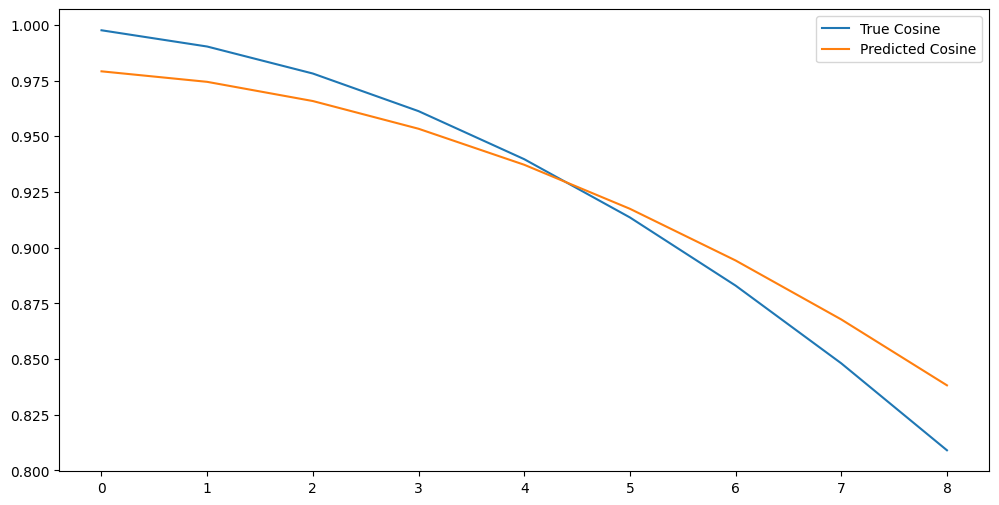

In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Example Usage for Cosine Function Extrapolation
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [64, 64]

model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)

# Create a dataset for the cosine function
def generate_cosine_data(seq_length, num_sequences):
    x = torch.linspace(0, 2 * math.pi/10, seq_length)
    data = torch.cos(x).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    return sequences

seq_length = 10
num_sequences = 10
data = generate_cosine_data(seq_length, num_sequences)

# Split into train and test sets
train_size = int(0.8 * num_sequences)
test_size = num_sequences - train_size

train_data = data[:train_size]
test_data = data[train_size:]

# Training Loop (Simplified)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    state = train_data[:, :-1, :]  # All but the last value as state
    input = train_data[:, 1:, :]  # All but the first value as input (next state)
    observation_target = train_data[:, 1:, :]  # Target is the next value
    
    state = state.reshape(-1, state_dim)
    input = input.reshape(-1, input_dim)
    observation_target = observation_target.reshape(-1, output_dim)
    
    next_state, observation = model(state, input)
    loss = criterion(next_state, state) + criterion(observation, observation_target)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Extrapolation on Test Data
model.eval()
with torch.no_grad():
    test_state = test_data[:, :-1, :]
    test_input = test_data[:, 1:, :]
    
    test_state = test_state.reshape(-1, state_dim)
    test_input = test_input.reshape(-1, input_dim)
    
    _, test_observation = model(test_state, test_input)
    
    # Reshape for plotting
    test_observation = test_observation.view(test_size, seq_length - 1, output_dim).squeeze(-1)
    test_target = test_data[:, 1:, :].squeeze(-1)

# Plot the extrapolation results
plt.figure(figsize=(12, 6))
plt.plot(test_target[0].cpu().numpy(), label="True Cosine")
plt.plot(test_observation[0].cpu().numpy(), label="Predicted Cosine")
plt.legend()
plt.show()


Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 10, Train Loss: 8.420e-01, Test Loss: 3.419e-01, Extrapolation Loss: 2.571e-01
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 20, Train Loss: 1.006e-01, Test Loss: 2.155e-02, Extrapolation Loss: 1.007e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 30, Train Loss: 4.119e-02, Test Loss: 2.628e-02, Extrapolation Loss: 3.555e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 40, Train Loss: 1.676e-02, Test Loss: 4.267e-03, Extrapolation Loss: 9.862e-03
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 50, Train Loss: 3.901e-03, Test Loss: 2.542e-03, Extrapolation Loss: 1.938e-04
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 60, Train Loss: 3.309e-03, Test Loss: 1.119e-03, Extrapolation Loss: 2.195e-04
Train Seq Length 40, Extrapolation Length 20, Frequency 1, Epoch 70, Train Loss: 4.340e-04, Test Loss: 3.156e-04, Extrapolation Loss: 2.

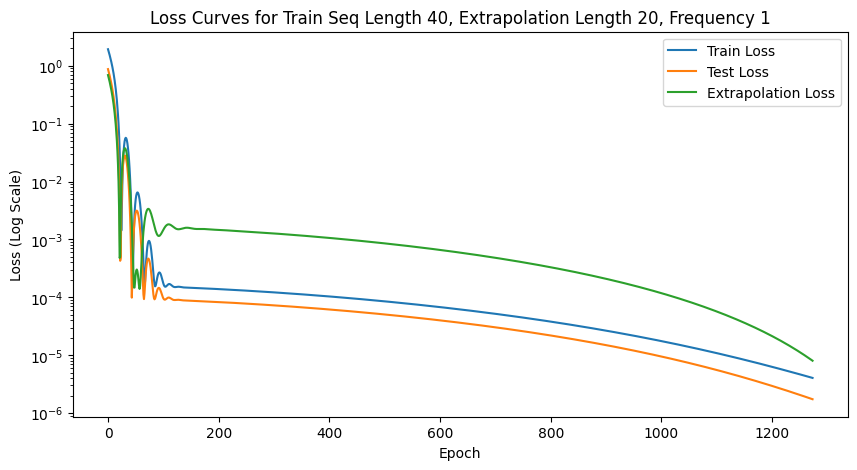

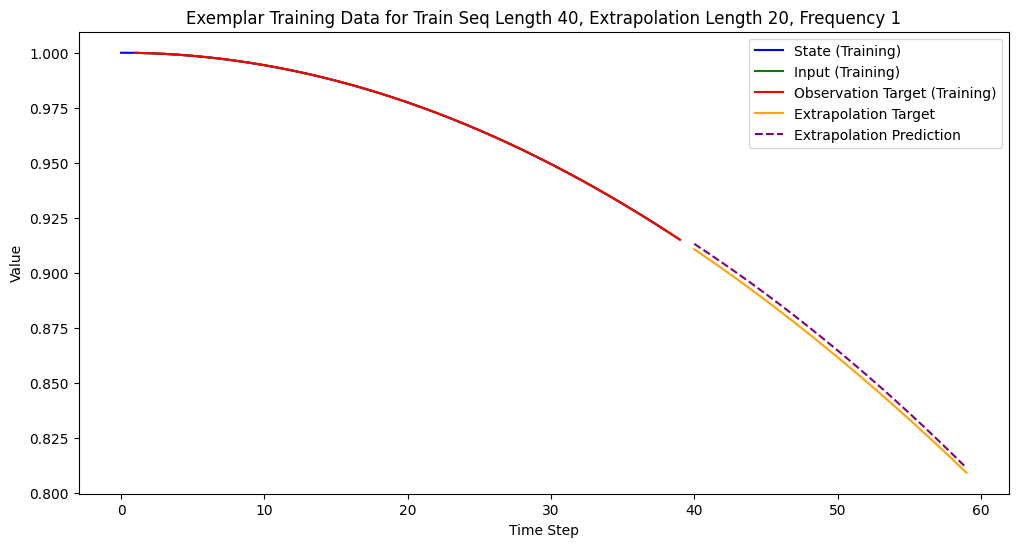

Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 10, Train Loss: 7.493e-01, Test Loss: 3.350e-01, Extrapolation Loss: 7.695e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 20, Train Loss: 8.002e-02, Test Loss: 3.209e-02, Extrapolation Loss: 3.457e-03
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 30, Train Loss: 4.641e-02, Test Loss: 2.035e-02, Extrapolation Loss: 6.153e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 40, Train Loss: 1.327e-02, Test Loss: 7.256e-03, Extrapolation Loss: 4.101e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 50, Train Loss: 6.516e-03, Test Loss: 2.583e-03, Extrapolation Loss: 1.403e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 60, Train Loss: 3.649e-03, Test Loss: 2.264e-03, Extrapolation Loss: 1.342e-02
Train Seq Length 40, Extrapolation Length 20, Frequency 2, Epoch 70, Train Loss: 1.980e-03, Test Loss: 9.961e-04, Extrapolation Loss: 1.

KeyboardInterrupt: 

In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

# Function to generate cosine data with varying frequencies
def generate_cosine_data(seq_length, num_sequences, frequency):
    x = torch.linspace(0, 2 * math.pi * frequency/10, seq_length)
    data = torch.cos(x).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    return sequences

# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [64, 64]
batch_size = 10
num_sequences = 10
frequencies = [1, 2, 3]  # Testing with a single frequency for simplicity
train_seq_lengths = [40, 60, 80]  # Different lengths of training sequences
extrapolation_lengths = [20, 40, 60]  # Lengths of extrapolation sequences
convergence_std_threshold = 1e-6  # Added line for the standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100

# Initialize performance data dictionary
performance_data = []

for train_seq_length in train_seq_lengths:
    for extrapolation_length in extrapolation_lengths:
        total_seq_length = train_seq_length + extrapolation_length
        
        for freq in frequencies:
            model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            criterion = nn.MSELoss()
            
            # Generate data
            data = generate_cosine_data(total_seq_length, num_sequences, freq)
            
            # Split into train and test sets
            train_size = int(0.8 * num_sequences)
            test_size = num_sequences - train_size
            
            train_data = data[:train_size]
            test_data = data[train_size:]
            
            train_losses = []
            test_losses = []
            best_loss = float('inf')
            patience_counter = 0
            
            epoch = 0
            while patience_counter < patience:
                model.train()
                optimizer.zero_grad()
                
                state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
                input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
                observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
                
                state = state.reshape(-1, state_dim)
                input = input.reshape(-1, input_dim)
                observation_target = observation_target.reshape(-1, output_dim)
                
                next_state, observation = model(state, input)
                loss = criterion(next_state, state) + criterion(observation, observation_target)
                
                loss.backward()
                optimizer.step()
                
                train_losses.append(loss.item())

                # Check convergence criteria based on the standard deviation of the last few training losses
                if len(train_losses) > n_pts:
                    recent_losses = train_losses[-n_pts:]
                    std_recent_losses = np.std(recent_losses)
                    if std_recent_losses < convergence_std_threshold:
                        patience_counter += 1
                    else:
                        patience_counter = 0
                else:
                    patience_counter = 0
                

                
                # Validation on test data
                model.eval()
                with torch.no_grad():
                    test_state = test_data[:, :train_seq_length-1, :]
                    test_input = test_data[:, 1:train_seq_length, :]
                    
                    test_state = test_state.reshape(-1, state_dim)
                    test_input = test_input.reshape(-1, input_dim)
                    
                    _, test_observation = model(test_state, test_input)
                    
                    extrap_state = test_data[:, train_seq_length-1:-1, :]  # Extrapolation part of the sequence
                    extrap_input = test_data[:, train_seq_length:, :]  # Extrapolation part of the sequence (next state)
                    extrap_target = test_data[:, train_seq_length:, :]  # Extrapolation target is the next value
                    
                    extrap_state = extrap_state.reshape(-1, state_dim)
                    extrap_input = extrap_input.reshape(-1, input_dim)
                    extrap_target = extrap_target.reshape(-1, output_dim)
                    
                    _, extrap_observation = model(extrap_state, extrap_input)
                    
                    test_loss = criterion(test_observation, test_data[:, 1:train_seq_length, :].reshape(-1, output_dim))
                    extrapolation_loss = criterion(extrap_observation, extrap_target)
                    test_losses.append((test_loss.item(), extrapolation_loss.item()))


                if (epoch + 1) % 10 == 0:
                    print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Frequency {freq}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
                
                epoch += 1
            
            # Save performance data
            performance_data.append({
                "train_seq_length": train_seq_length,
                "extrapolation_length": extrapolation_length,
                "frequency": freq,
                "final_train_loss": train_losses[-1],
                "final_test_loss": test_losses[-1][0],
                "final_extrapolation_loss": test_losses[-1][1]
            })
            
            # Plot loss curves
            train_losses = np.array(train_losses)
            test_losses = np.array(test_losses)
            
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses[:, 0], label="Test Loss")
            plt.plot(test_losses[:, 1], label="Extrapolation Loss")
            plt.yscale('log')
            plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Frequency {freq}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss (Log Scale)")
            plt.legend()
            plt.show()
            
            # Plot exemplar training data
            exemplar_index = 0
            exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
            exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
            exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
            exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

            # Get the model prediction for the extrapolation regime
            model.eval()
            with torch.no_grad():
                extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
                extrap_input = train_data[exemplar_index, train_seq_length:, :]
                
                extrap_state = extrap_state.reshape(-1, state_dim)
                extrap_input = extrap_input.reshape(-1, input_dim)
                
                _, extrap_prediction = model(extrap_state, extrap_input)
                extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

            plt.figure(figsize=(12, 6))
            plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
            plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
            plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
            plt.plot(range(train_seq_length, total_seq_length), exemplar_extrapolation, label="Extrapolation Target", color='orange')
            plt.plot(range(train_seq_length, total_seq_length), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
            plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Frequency {freq}")
            plt.xlabel("Time Step")
            plt.ylabel("Value")
            plt.legend()
            plt.show()


# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

# Plot a seaborn barplot of the final train, test, and extrapolation losses
plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Train Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_test_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Test Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Test Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Extrapolation Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}, Frequency {data['frequency']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
    print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


In [8]:
performance_df

,train_seq_length,extrapolation_length,frequency,final_train_loss,final_test_loss,final_extrapolation_loss
0,20,10,1,0.000012,0.000004,0.017147
1,20,10,2,0.000009,0.000005,0.000013
2,20,10,3,0.000011,0.000004,0.000011
3,20,20,1,0.000014,0.000003,0.012379
4,20,20,2,0.000008,0.000004,0.000004
5,20,20,3,0.000003,0.000001,0.000002
6,20,30,1,0.000006,0.000003,0.006374
7,20,30,2,0.000005,0.000003,0.000098
8,20,30,3,0.000012,0.000006,0.000009
9,30,10,1,0.000007,0.000004,0.002398


# Harmonic Oscillator - SSKAN

Train Seq Length 10, Extrapolation Length 110, Epoch 10, Train Loss: 4.571e-01, Test Loss: 1.981e-01, Extrapolation Loss: 1.872e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 20, Train Loss: 1.291e-01, Test Loss: 4.430e-02, Extrapolation Loss: 3.076e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 30, Train Loss: 2.250e-02, Test Loss: 6.310e-03, Extrapolation Loss: 8.360e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 40, Train Loss: 2.548e-02, Test Loss: 7.036e-03, Extrapolation Loss: 7.661e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 50, Train Loss: 8.376e-03, Test Loss: 1.981e-03, Extrapolation Loss: 5.183e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 60, Train Loss: 6.846e-03, Test Loss: 1.833e-03, Extrapolation Loss: 5.084e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 70, Train Loss: 3.863e-03, Test Loss: 9.770e-04, Extrapolation Loss: 5.436e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 80, Train Loss: 3.225e-

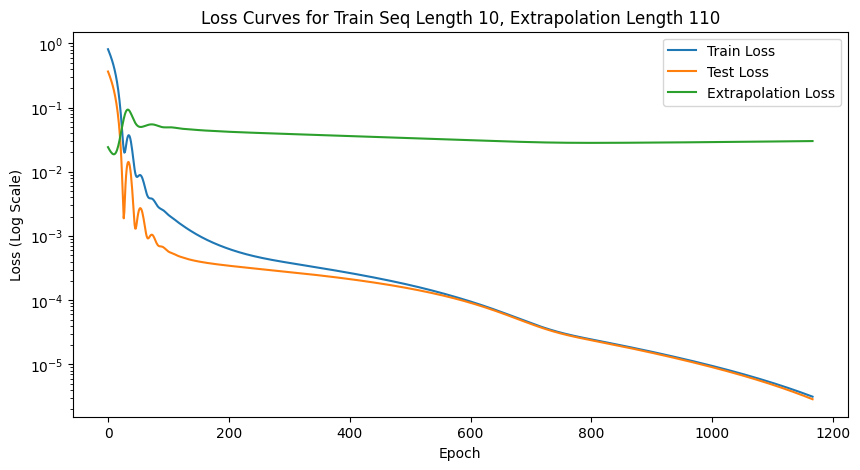

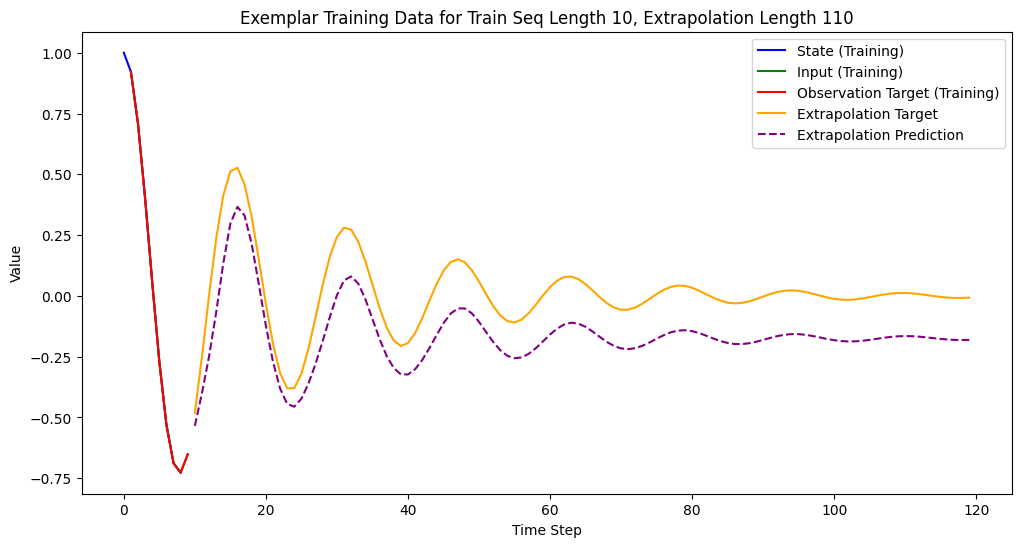

Train Seq Length 15, Extrapolation Length 105, Epoch 10, Train Loss: 3.669e-01, Test Loss: 1.473e-01, Extrapolation Loss: 1.250e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 20, Train Loss: 1.247e-01, Test Loss: 4.357e-02, Extrapolation Loss: 8.737e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 30, Train Loss: 3.723e-02, Test Loss: 2.413e-02, Extrapolation Loss: 1.546e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 40, Train Loss: 3.513e-02, Test Loss: 1.541e-02, Extrapolation Loss: 8.460e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 50, Train Loss: 1.821e-02, Test Loss: 1.032e-02, Extrapolation Loss: 2.113e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 60, Train Loss: 1.333e-02, Test Loss: 6.584e-03, Extrapolation Loss: 1.005e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 70, Train Loss: 8.517e-03, Test Loss: 4.479e-03, Extrapolation Loss: 7.051e-04
Train Seq Length 15, Extrapolation Length 105, Epoch 80, Train Loss: 5.516e-

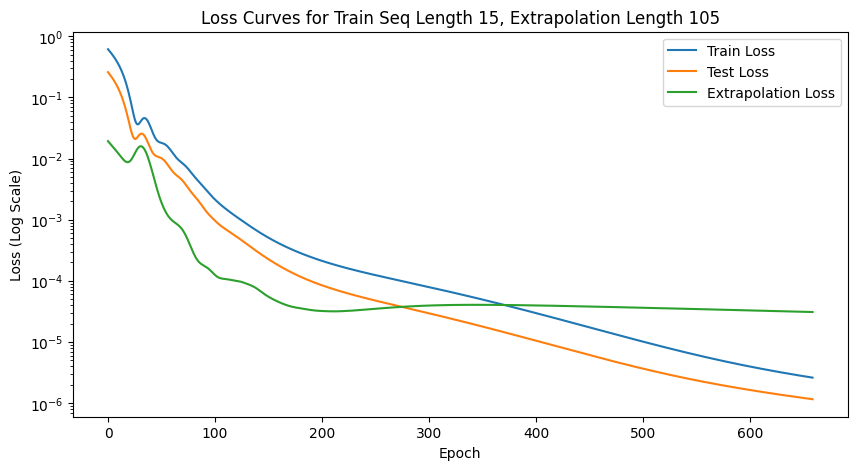

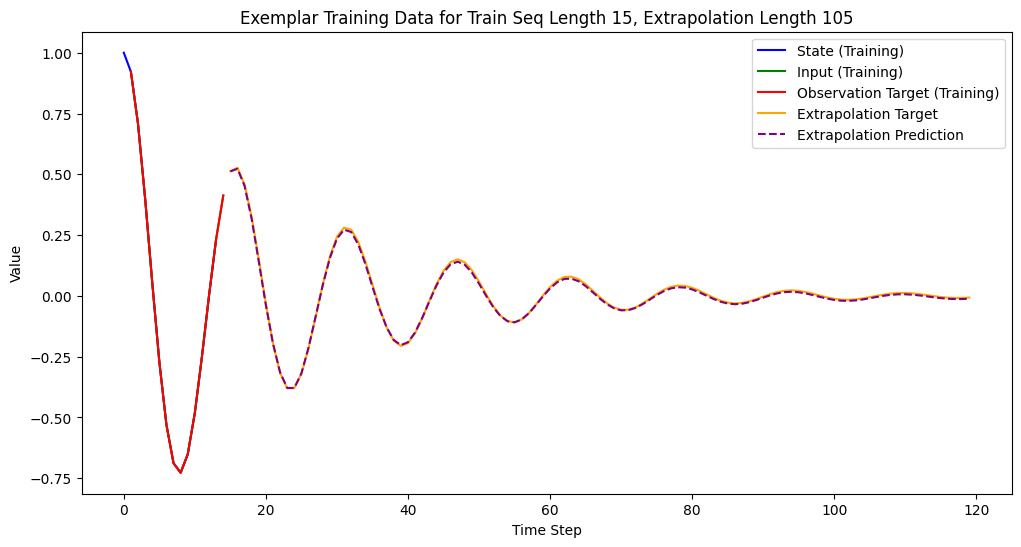

Train Seq Length 30, Extrapolation Length 90, Epoch 10, Train Loss: 2.164e-01, Test Loss: 8.581e-02, Extrapolation Loss: 3.820e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 20, Train Loss: 5.910e-02, Test Loss: 1.913e-02, Extrapolation Loss: 2.876e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 30, Train Loss: 2.845e-02, Test Loss: 1.630e-02, Extrapolation Loss: 6.277e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 40, Train Loss: 1.874e-02, Test Loss: 8.094e-03, Extrapolation Loss: 2.365e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 50, Train Loss: 1.173e-02, Test Loss: 6.288e-03, Extrapolation Loss: 7.190e-04
Train Seq Length 30, Extrapolation Length 90, Epoch 60, Train Loss: 7.089e-03, Test Loss: 3.602e-03, Extrapolation Loss: 2.877e-04
Train Seq Length 30, Extrapolation Length 90, Epoch 70, Train Loss: 4.409e-03, Test Loss: 2.338e-03, Extrapolation Loss: 1.603e-04
Train Seq Length 30, Extrapolation Length 90, Epoch 80, Train Loss: 2.413e-03, Test

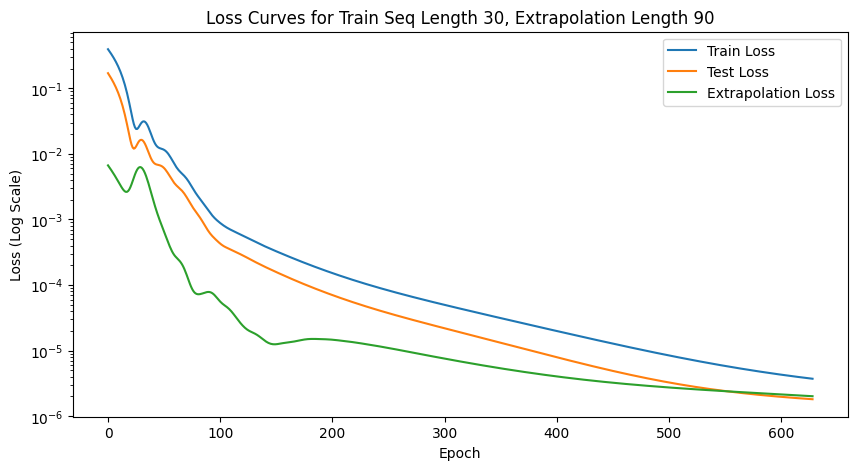

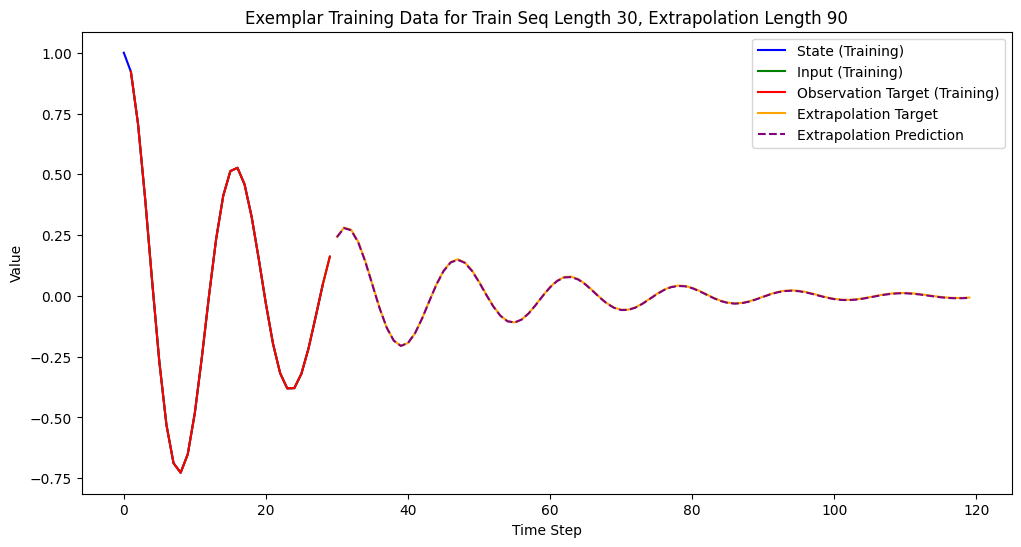

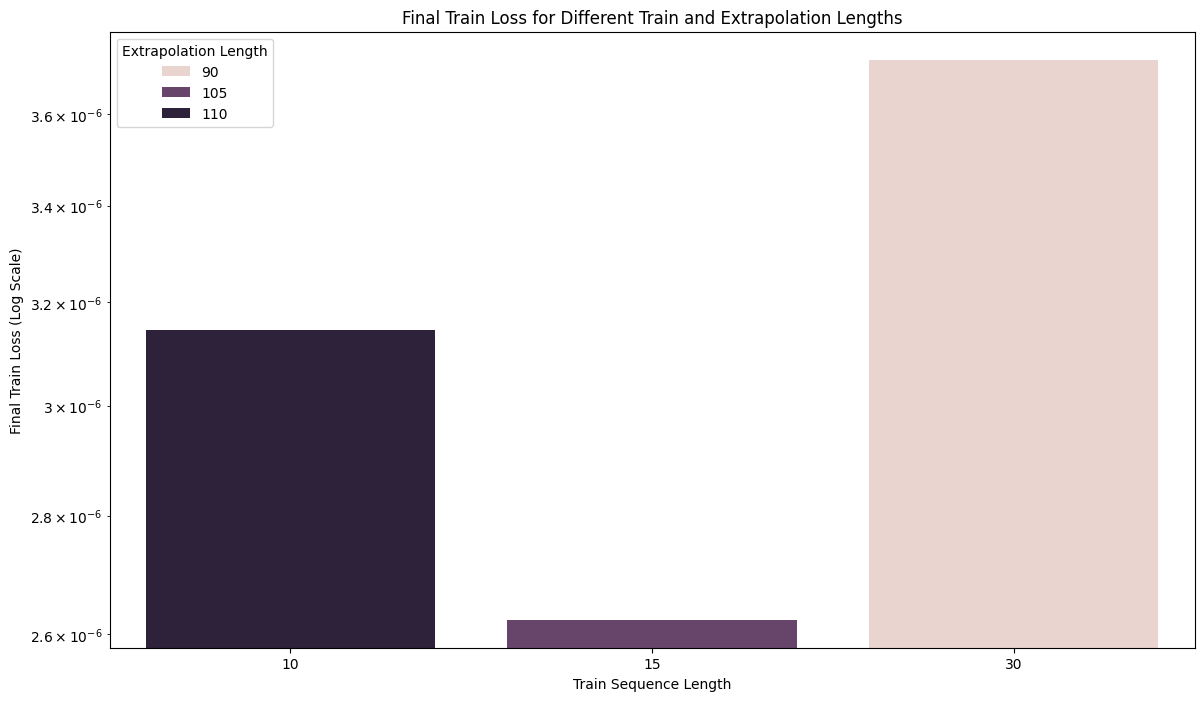

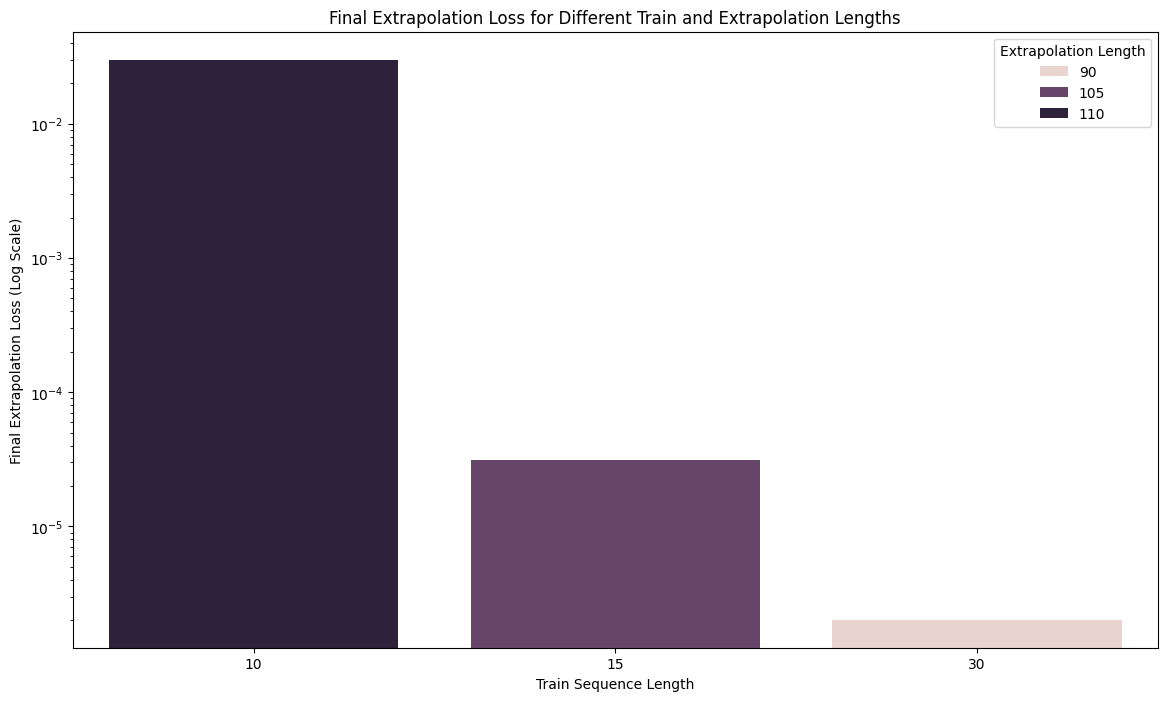

Train Seq Length 10, Extrapolation Length 110:
  Final Train Loss: 3.144e-06
  Final Test Loss: 2.869e-06
  Final Extrapolation Loss: 3.005e-02
Train Seq Length 15, Extrapolation Length 105:
  Final Train Loss: 2.624e-06
  Final Test Loss: 1.164e-06
  Final Extrapolation Loss: 3.099e-05
Train Seq Length 30, Extrapolation Length 90:
  Final Train Loss: 3.725e-06
  Final Test Loss: 1.815e-06
  Final Extrapolation Loss: 2.017e-06


In [30]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

# Damped harmonic oscillator function
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x  = exp * 2 * A * cos
    return x

# Function to generate oscillator data with given parameters
def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length/100, seq_length)  # Adjust time scaling as needed
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times

# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [64, 64]
batch_size = 10
num_sequences = 10
total_seq_length = 120
train_seq_lengths = [10, 15, 30]  # Different lengths of training sequences

convergence_std_threshold = 1e-6  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100
d, w0 = 4, 40

# Initialize performance data dictionary
performance_data = []

for train_seq_length in train_seq_lengths:
    extrapolation_length = total_seq_length - train_seq_length
    
    model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Generate data
    train_data, train_times = generate_oscillator_data(total_seq_length, num_sequences, d, w0)
    
    # Split into train and test sets
    train_size = int(num_sequences)

    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        
        state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
        input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
        observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
        
        state = state.reshape(-1, state_dim)
        input = input.reshape(-1, input_dim)
        observation_target = observation_target.reshape(-1, output_dim)
        
        next_state, observation = model(state, input)
        loss = criterion(next_state, state) + criterion(observation, observation_target)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():
            test_state = train_data[:, :train_seq_length-1, :]
            test_input = train_data[:, 1:train_seq_length, :]
            
            test_state = test_state.reshape(-1, state_dim)
            test_input = test_input.reshape(-1, input_dim)
            
            _, test_observation = model(test_state, test_input)
            
            extrap_state = train_data[:, train_seq_length-1:-1, :]  # Extrapolation part of the sequence
            extrap_input = train_data[:, train_seq_length:, :]  # Extrapolation part of the sequence (next state)
            extrap_target = train_data[:, train_seq_length:, :]  # Extrapolation target is the next value
            
            extrap_state = extrap_state.reshape(-1, state_dim)
            extrap_input = extrap_input.reshape(-1, input_dim)
            extrap_target = extrap_target.reshape(-1, output_dim)
            
            _, extrap_observation = model(extrap_state, extrap_input)
            
            test_loss = criterion(test_observation, train_data[:, 1:train_seq_length, :].reshape(-1, output_dim))
            extrapolation_loss = criterion(extrap_observation, extrap_target)
            test_losses.append((test_loss.item(), extrapolation_loss.item()))

        if (epoch + 1) % 10 == 0:
            print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_seq_length,
        "extrapolation_length": extrapolation_length,
        "final_train_loss": train_losses[-1],
        "final_test_loss": test_losses[-1][0],
        "final_extrapolation_loss": test_losses[-1][1]
    })
    
    # Plot loss curves
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses[:, 0], label="Test Loss")
    plt.plot(test_losses[:, 1], label="Extrapolation Loss")
    plt.yscale('log')
    plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()
    
    # Plot exemplar training data
    exemplar_index = 0
    exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
    exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

    # Get the model prediction for the extrapolation regime
    model.eval()
    with torch.no_grad():
        extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
        extrap_input = train_data[exemplar_index, train_seq_length:, :]
        
        extrap_state = extrap_state.reshape(-1, state_dim)
        extrap_input = extrap_input.reshape(-1, input_dim)
        
        _, extrap_prediction = model(extrap_state, extrap_input)
        extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
    plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
    plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
    plt.plot(range(train_seq_length, total_seq_length), exemplar_extrapolation, label="Extrapolation Target", color='orange')
    plt.plot(range(train_seq_length, total_seq_length), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
    plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

# Plot a seaborn barplot of the final train, test, and extrapolation losses
plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Train Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Extrapolation Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
    print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


# Harmonic Oscillator - NN

In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

# Damped harmonic oscillator function
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x  = exp * 2 * A * cos
    return x

# Function to generate oscillator data with given parameters
def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length/100, seq_length)  # Adjust time scaling as needed
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times

# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
nn_layers = [64, 64]
batch_size = 10
num_sequences = 10
total_seq_length = 120
train_seq_lengths = [10, 15, 30]  # Different lengths of training sequences

convergence_std_threshold = 1e-6  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100
d, w0 = 4, 40

# Initialize performance data dictionary
performance_data = []

for train_seq_length in train_seq_lengths:
    extrapolation_length = total_seq_length - train_seq_length
    
    model = NN(input_dim, nn_layers, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Generate data
    train_data, train_times = generate_oscillator_data(total_seq_length, num_sequences, d, w0)
    
    # Split into train and test sets
    train_size = int(num_sequences)

    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        
        state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
        input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
        observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
        
        state = state.reshape(-1, state_dim)
        input = input.reshape(-1, input_dim)
        observation_target = observation_target.reshape(-1, output_dim)
        
        next_state, observation = model(input)
        loss = criterion(next_state, state) + criterion(observation, observation_target)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():
            test_state = train_data[:, :train_seq_length-1, :]
            test_input = train_data[:, 1:train_seq_length, :]
            
            test_state = test_state.reshape(-1, state_dim)
            test_input = test_input.reshape(-1, input_dim)
            
            _, test_observation = model(test_state, test_input)
            
            extrap_state = train_data[:, train_seq_length-1:-1, :]  # Extrapolation part of the sequence
            extrap_input = train_data[:, train_seq_length:, :]  # Extrapolation part of the sequence (next state)
            extrap_target = train_data[:, train_seq_length:, :]  # Extrapolation target is the next value
            
            extrap_state = extrap_state.reshape(-1, state_dim)
            extrap_input = extrap_input.reshape(-1, input_dim)
            extrap_target = extrap_target.reshape(-1, output_dim)
            
            _, extrap_observation = model(extrap_state, extrap_input)
            
            test_loss = criterion(test_observation, train_data[:, 1:train_seq_length, :].reshape(-1, output_dim))
            extrapolation_loss = criterion(extrap_observation, extrap_target)
            test_losses.append((test_loss.item(), extrapolation_loss.item()))

        if (epoch + 1) % 10 == 0:
            print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_seq_length,
        "extrapolation_length": extrapolation_length,
        "final_train_loss": train_losses[-1],
        "final_test_loss": test_losses[-1][0],
        "final_extrapolation_loss": test_losses[-1][1]
    })
    
    # Plot loss curves
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses[:, 0], label="Test Loss")
    plt.plot(test_losses[:, 1], label="Extrapolation Loss")
    plt.yscale('log')
    plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()
    
    # Plot exemplar training data
    exemplar_index = 0
    exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
    exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

    # Get the model prediction for the extrapolation regime
    model.eval()
    with torch.no_grad():
        extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
        extrap_input = train_data[exemplar_index, train_seq_length:, :]
        
        extrap_state = extrap_state.reshape(-1, state_dim)
        extrap_input = extrap_input.reshape(-1, input_dim)
        
        _, extrap_prediction = model(extrap_state, extrap_input)
        extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
    plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
    plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
    plt.plot(range(train_seq_length, total_seq_length), exemplar_extrapolation, label="Extrapolation Target", color='orange')
    plt.plot(range(train_seq_length, total_seq_length), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
    plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

# Plot a seaborn barplot of the final train, test, and extrapolation losses
plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Train Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Extrapolation Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
    print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


ValueError: too many values to unpack (expected 2)

# Harmonic Oscillator - SSKAN with time input

Train Seq Length 10, Extrapolation Length 110, Epoch 10, Train Loss: 1.227e-01, Test Loss: 1.038e-01, Extrapolation Loss: 8.602e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 20, Train Loss: 2.379e-02, Test Loss: 2.405e-02, Extrapolation Loss: 1.094e-01
Train Seq Length 10, Extrapolation Length 110, Epoch 30, Train Loss: 1.985e-02, Test Loss: 1.704e-02, Extrapolation Loss: 6.206e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 40, Train Loss: 4.038e-03, Test Loss: 3.886e-03, Extrapolation Loss: 2.734e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 50, Train Loss: 1.665e-03, Test Loss: 1.308e-03, Extrapolation Loss: 1.831e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 60, Train Loss: 5.316e-04, Test Loss: 5.937e-04, Extrapolation Loss: 1.564e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 70, Train Loss: 4.160e-04, Test Loss: 3.884e-04, Extrapolation Loss: 1.645e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 80, Train Loss: 3.390e-

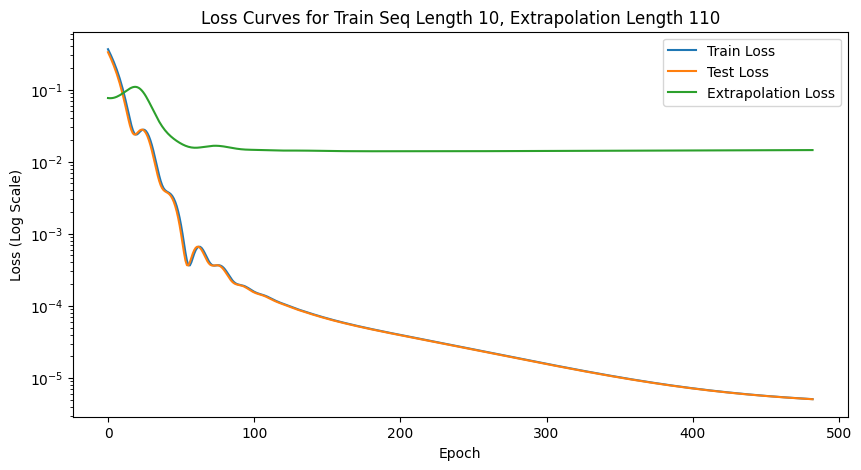

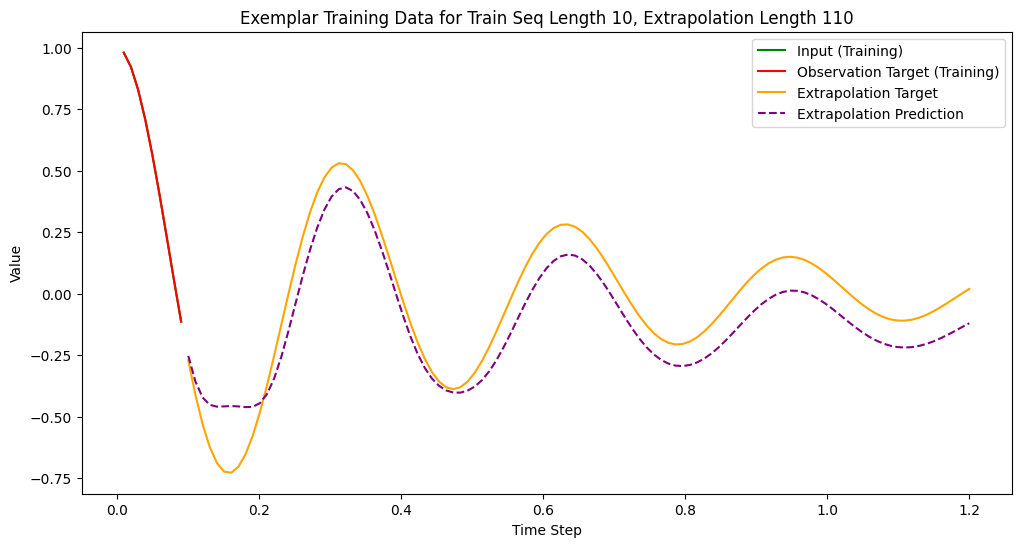

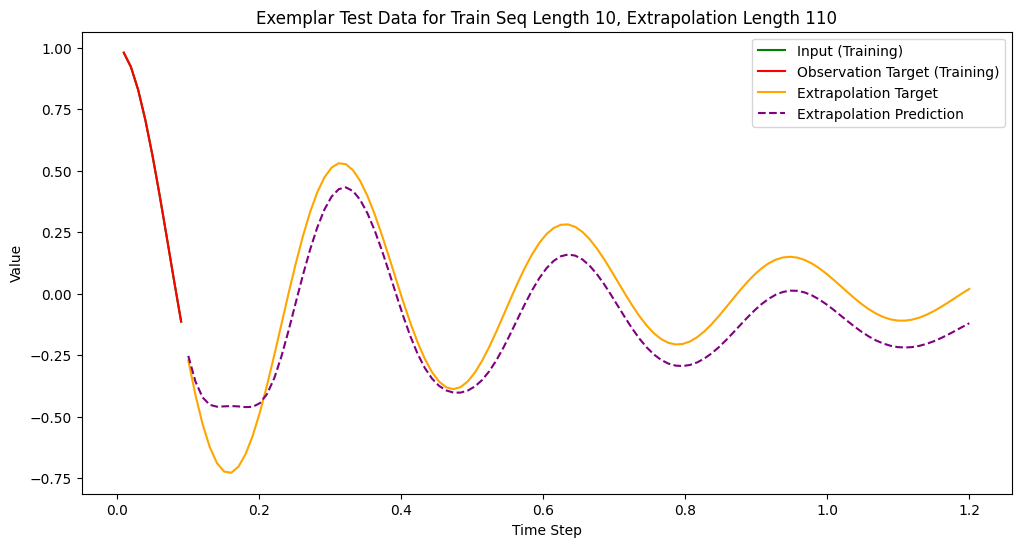

Train Seq Length 15, Extrapolation Length 105, Epoch 10, Train Loss: 2.269e-01, Test Loss: 2.125e-01, Extrapolation Loss: 5.095e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 20, Train Loss: 9.296e-02, Test Loss: 8.134e-02, Extrapolation Loss: 3.610e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 30, Train Loss: 1.116e-02, Test Loss: 8.340e-03, Extrapolation Loss: 1.034e-01
Train Seq Length 15, Extrapolation Length 105, Epoch 40, Train Loss: 1.044e-02, Test Loss: 1.062e-02, Extrapolation Loss: 2.582e-01
Train Seq Length 15, Extrapolation Length 105, Epoch 50, Train Loss: 3.400e-03, Test Loss: 2.858e-03, Extrapolation Loss: 1.936e-01
Train Seq Length 15, Extrapolation Length 105, Epoch 60, Train Loss: 2.345e-03, Test Loss: 2.371e-03, Extrapolation Loss: 1.362e-01
Train Seq Length 15, Extrapolation Length 105, Epoch 70, Train Loss: 1.464e-03, Test Loss: 1.342e-03, Extrapolation Loss: 1.498e-01
Train Seq Length 15, Extrapolation Length 105, Epoch 80, Train Loss: 1.002e-

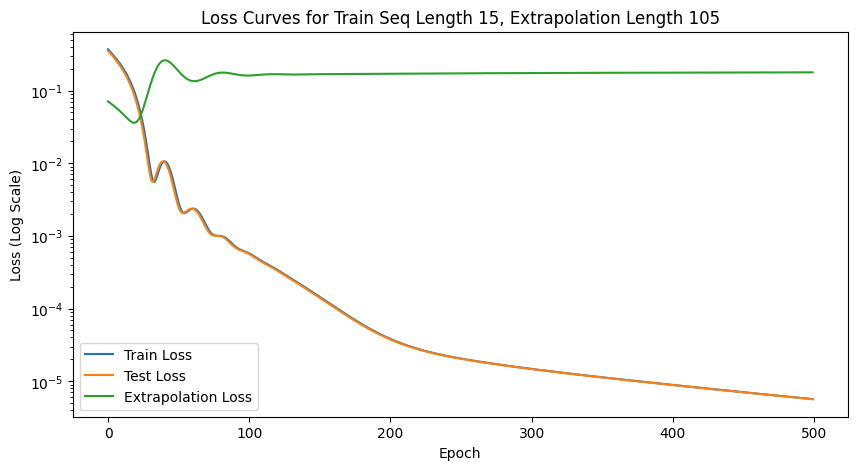

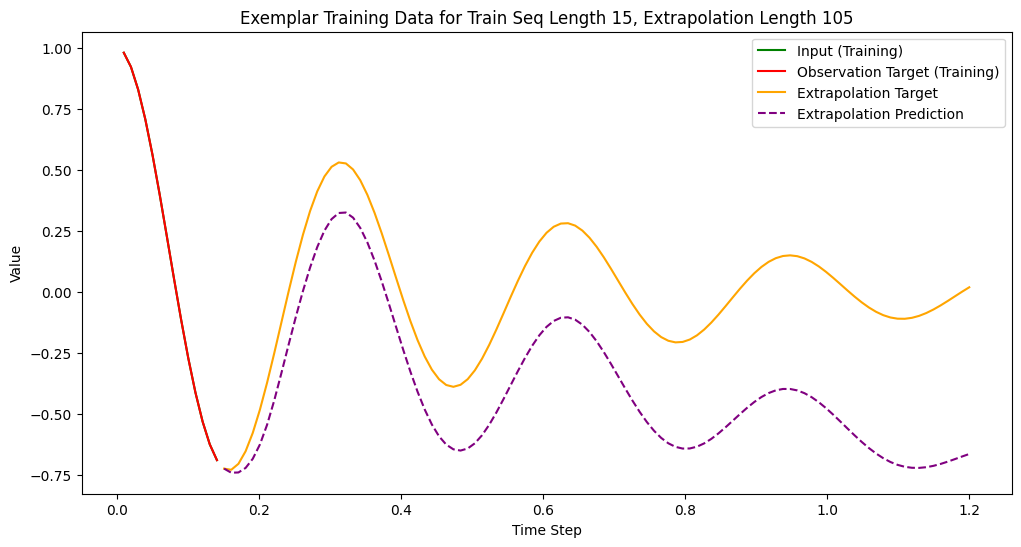

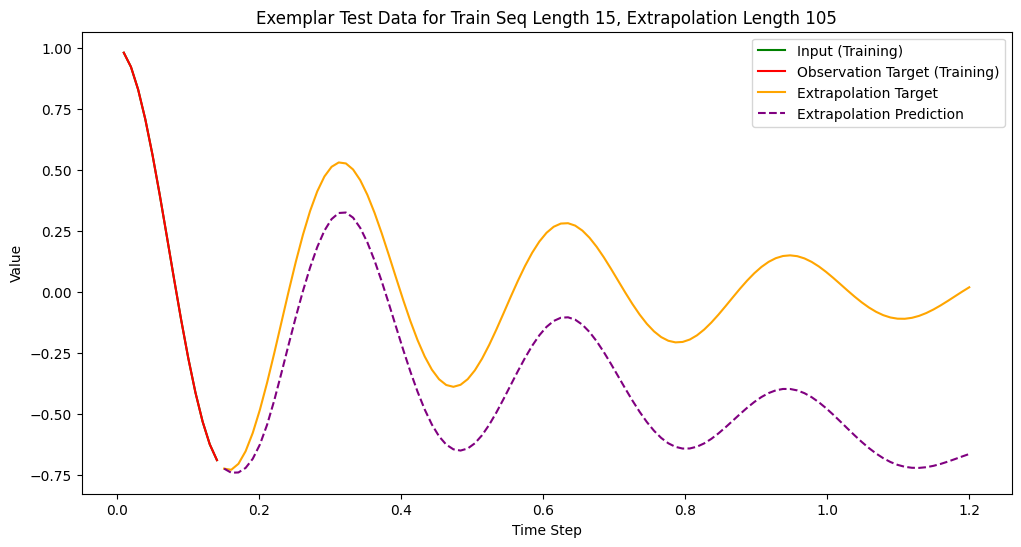

Train Seq Length 30, Extrapolation Length 90, Epoch 10, Train Loss: 1.770e-01, Test Loss: 1.645e-01, Extrapolation Loss: 2.617e-02
Train Seq Length 30, Extrapolation Length 90, Epoch 20, Train Loss: 5.958e-02, Test Loss: 4.999e-02, Extrapolation Loss: 1.068e-02
Train Seq Length 30, Extrapolation Length 90, Epoch 30, Train Loss: 1.093e-02, Test Loss: 1.191e-02, Extrapolation Loss: 1.157e-02
Train Seq Length 30, Extrapolation Length 90, Epoch 40, Train Loss: 1.320e-02, Test Loss: 1.164e-02, Extrapolation Loss: 4.182e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 50, Train Loss: 4.900e-03, Test Loss: 4.920e-03, Extrapolation Loss: 5.836e-04
Train Seq Length 30, Extrapolation Length 90, Epoch 60, Train Loss: 4.094e-03, Test Loss: 3.845e-03, Extrapolation Loss: 2.949e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 70, Train Loss: 2.597e-03, Test Loss: 2.571e-03, Extrapolation Loss: 8.076e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 80, Train Loss: 2.091e-03, Test

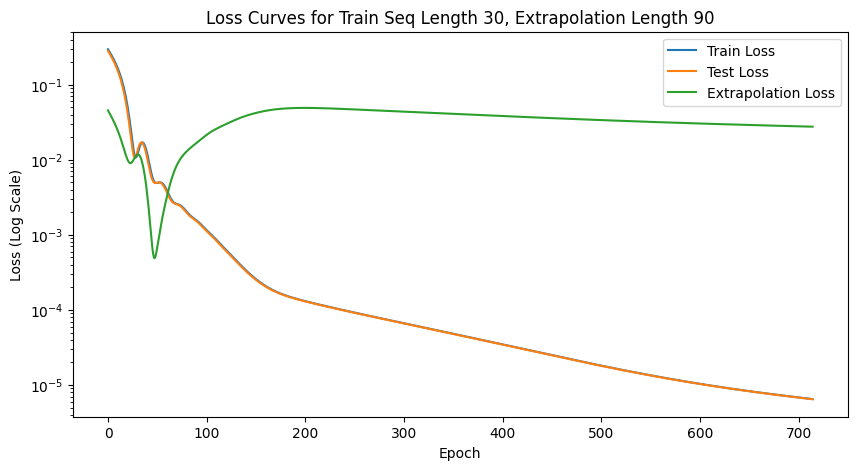

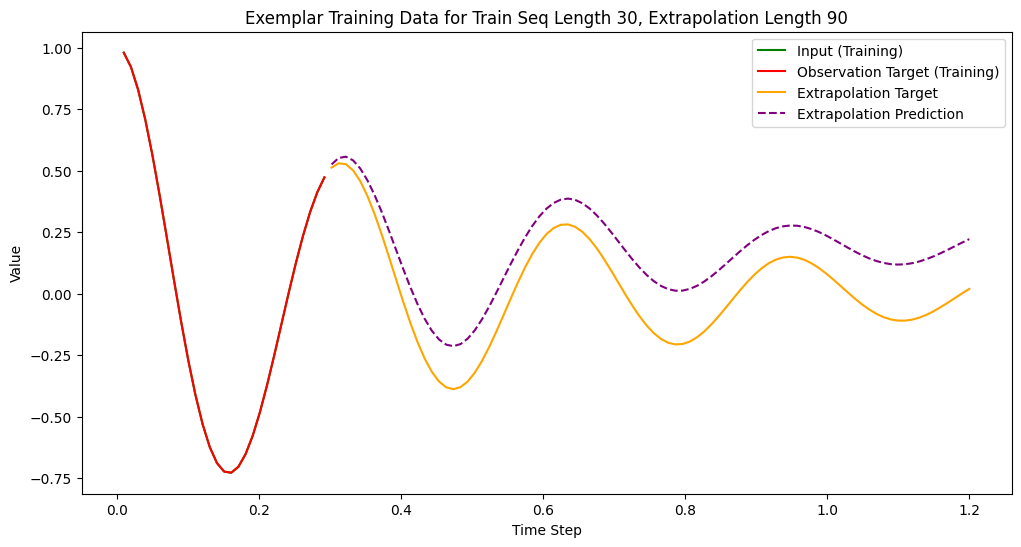

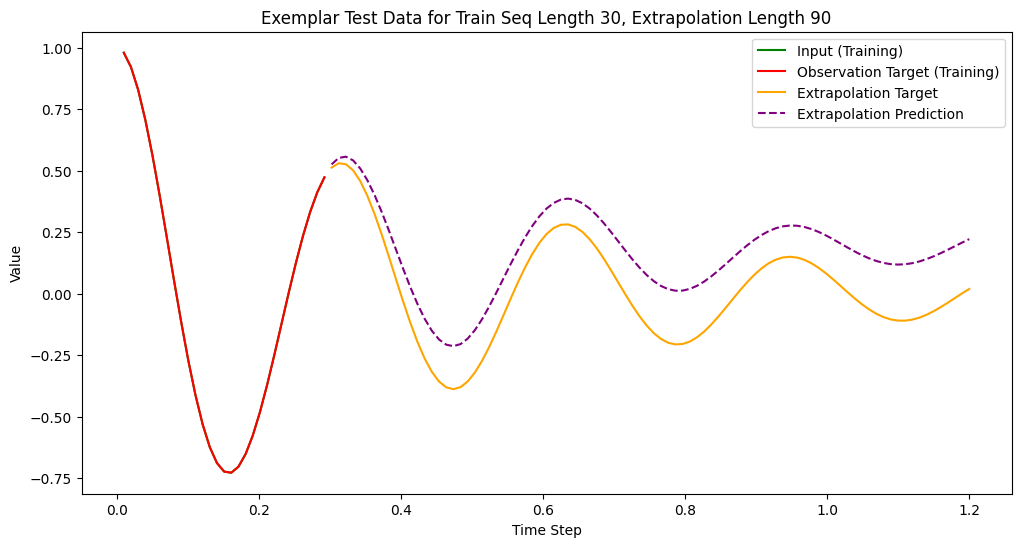

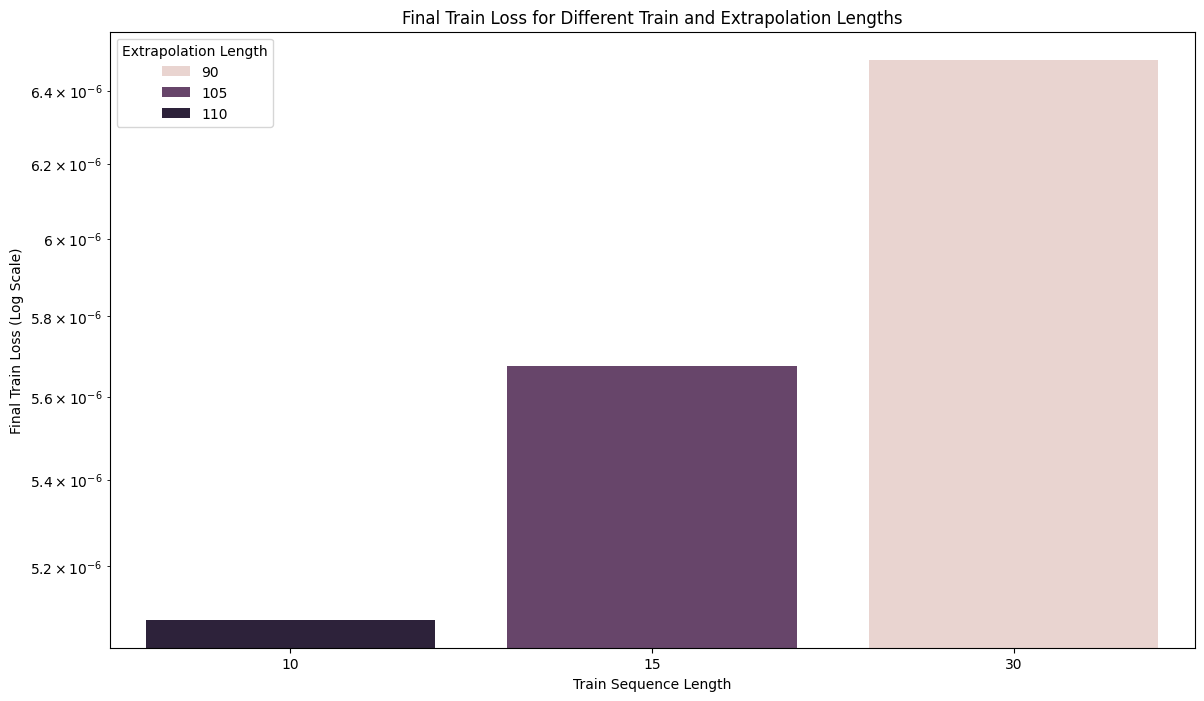

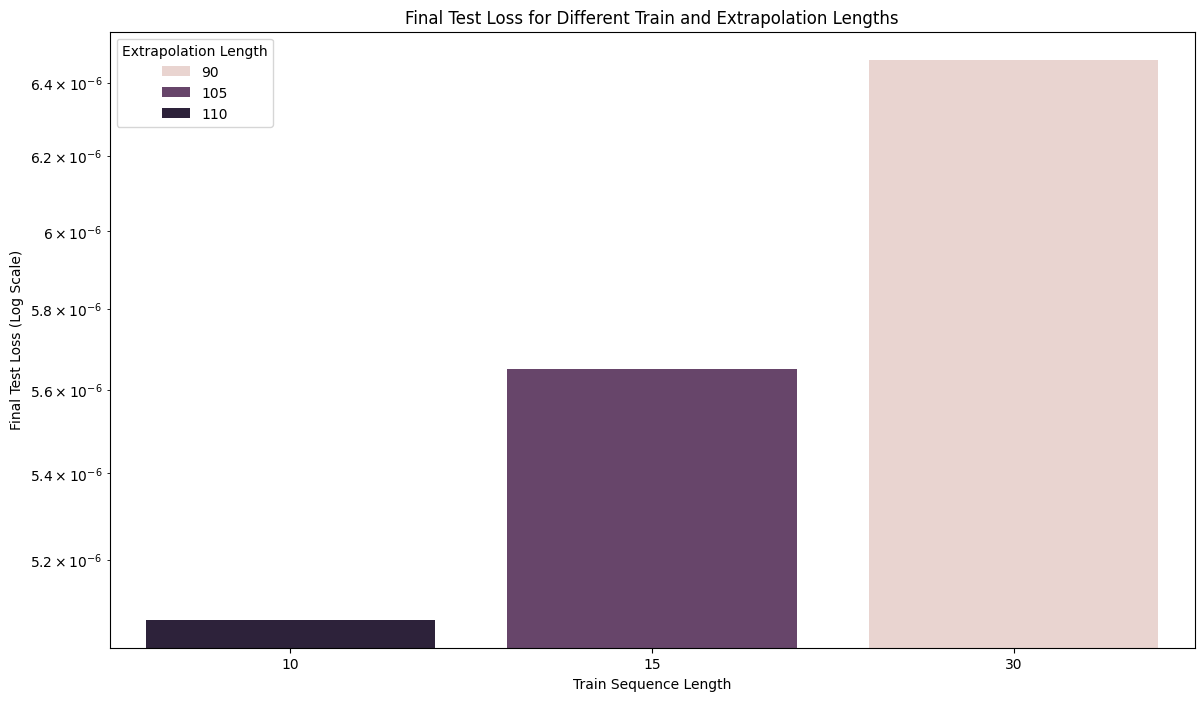

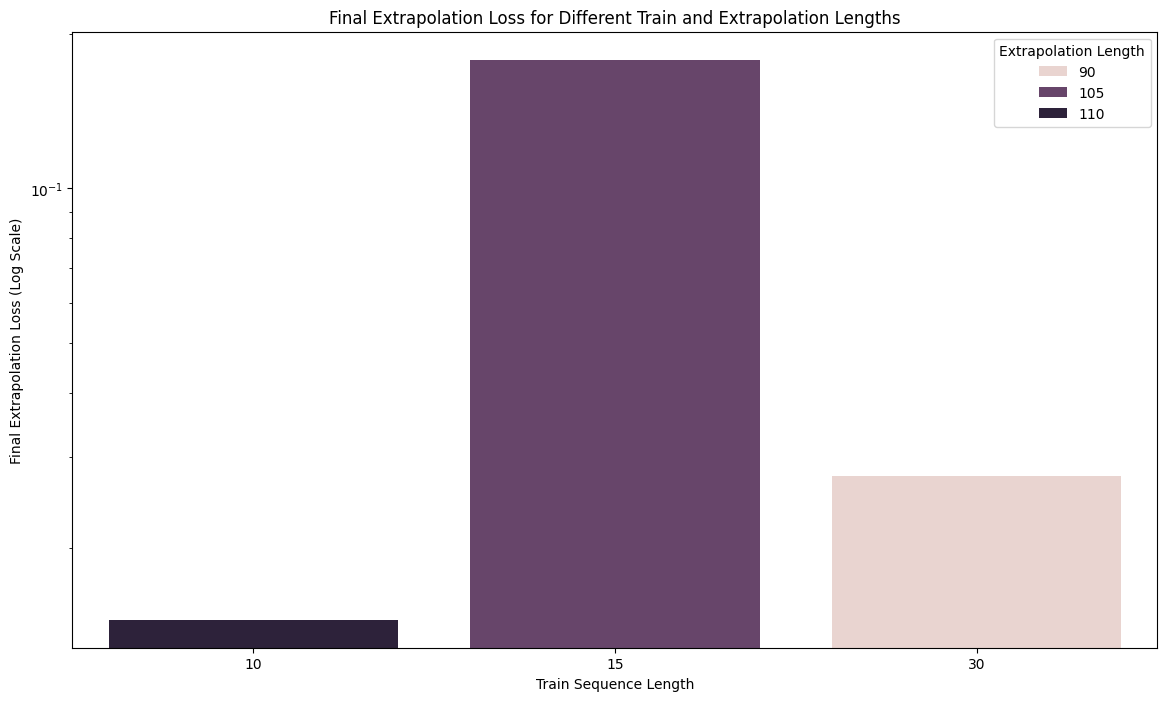

Train Seq Length 10, Extrapolation Length 110:
  Final Train Loss: 5.080e-06
  Final Test Loss: 5.066e-06
  Final Extrapolation Loss: 1.452e-02
Train Seq Length 15, Extrapolation Length 105:
  Final Train Loss: 5.675e-06
  Final Test Loss: 5.651e-06
  Final Extrapolation Loss: 1.779e-01
Train Seq Length 30, Extrapolation Length 90:
  Final Train Loss: 6.488e-06
  Final Test Loss: 6.465e-06
  Final Extrapolation Loss: 2.761e-02


In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

# Damped harmonic oscillator function
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x  = exp * 2 * A * cos
    return x

# Function to generate oscillator data with given parameters
def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length/100, seq_length)  # Adjust time scaling as needed
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    return sequences, t

# Parameters
state_dim = 1
input_dim = 2
output_dim = 1
kan_layers = [64, 64]
batch_size = 10
num_sequences = 10
total_seq_length = 120
train_seq_lengths = [10, 15, 30]  # Different lengths of training sequences
convergence_std_threshold = 1e-6  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100
d, w0 = 2, 20

# Initialize performance data dictionary
performance_data = []

for train_seq_length in train_seq_lengths:
    extrapolation_length = total_seq_length - train_seq_length
        
    model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Generate data
    data, t = generate_oscillator_data(total_seq_length, num_sequences, d, w0)
    t = t.unsqueeze(0).repeat(num_sequences, 1)
    
    # Split into train and test sets
    train_size = int(0.8 * num_sequences)
    test_size = num_sequences - train_size
    
    train_data = data[:train_size]
    train_time = t[:train_size]
    test_data = data[train_size:]
    test_time = t[train_size:]
    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        
        state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
        input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
        time_input = train_time[:, 1:train_seq_length].unsqueeze(-1)
        combined_input = torch.cat((input, time_input), dim=-1)
        observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
        
        state = state.reshape(-1, state_dim)
        combined_input = combined_input.reshape(-1, input_dim)
        observation_target = observation_target.reshape(-1, output_dim)
        
        observation = model(state, combined_input)
        loss = criterion(observation[-1], observation_target)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():
            test_state = test_data[:, :train_seq_length-1, :]
            test_input = test_data[:, 1:train_seq_length, :]
            test_time_input = test_time[:, 1:train_seq_length].unsqueeze(-1)
            test_combined_input = torch.cat((test_input, test_time_input), dim=-1)
            
            test_state = test_state.reshape(-1, state_dim)
            test_combined_input = test_combined_input.reshape(-1, input_dim)
            
            test_observation = model(test_state, test_combined_input)
            test_loss = criterion(test_observation[-1], test_data[:, 1:train_seq_length, :].reshape(-1, output_dim))
            
            extrap_state = test_data[:, train_seq_length-1:-1, :]  # Extrapolation part of the sequence
            extrap_input = test_data[:, train_seq_length:, :]  # Extrapolation part of the sequence (next state)
            extrap_time_input = test_time[:, train_seq_length:].unsqueeze(-1)
            extrap_combined_input = torch.cat((extrap_input, extrap_time_input), dim=-1)
            extrap_target = test_data[:, train_seq_length:, :]  # Extrapolation target is the next value
            
            extrap_state = extrap_state.reshape(-1, state_dim)
            extrap_combined_input = extrap_combined_input.reshape(-1, input_dim)
            extrap_target = extrap_target.reshape(-1, output_dim)
            
            extrap_observation = model(extrap_state, extrap_combined_input)
            extrapolation_loss = criterion(extrap_observation[-1], extrap_target)
            test_losses.append((test_loss.item(), extrapolation_loss.item()))

        if (epoch + 1) % 10 == 0:
            print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_seq_length,
        "extrapolation_length": extrapolation_length,
        "final_train_loss": train_losses[-1],
        "final_test_loss": test_losses[-1][0],
        "final_extrapolation_loss": test_losses[-1][1]
    })
    
    # Plot loss curves
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses[:, 0], label="Test Loss")
    plt.plot(test_losses[:, 1], label="Extrapolation Loss")
    plt.yscale('log')
    plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()
    
    # Plot exemplar training data
    exemplar_index = 0
    exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
    exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_train_time = train_time[exemplar_index, 1:train_seq_length].cpu().numpy()
    exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()
    exemplar_extrap_time = train_time[exemplar_index, train_seq_length:].cpu().numpy()

    # Get the model prediction for the extrapolation regime
    model.eval()
    with torch.no_grad():
        extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
        extrap_input = train_data[exemplar_index, train_seq_length:, :]
        extrap_time = train_time[exemplar_index, train_seq_length:].unsqueeze(-1)
        extrap_combined_input = torch.cat((extrap_input, extrap_time), dim=-1)
        
        extrap_state = extrap_state.reshape(-1, state_dim)
        extrap_combined_input = extrap_combined_input.reshape(-1, input_dim)
        
        extrap_prediction = model(extrap_state, extrap_combined_input)
        extrap_prediction = extrap_prediction[-1].cpu().numpy().reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(exemplar_train_time, exemplar_input, label="Input (Training)", color='green')
    plt.plot(exemplar_train_time, exemplar_target, label="Observation Target (Training)", color='red')
    plt.plot(exemplar_extrap_time, exemplar_extrapolation, label="Extrapolation Target", color='orange')
    plt.plot(exemplar_extrap_time, extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
    plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # Plot exemplar test data
    exemplar_test_state = test_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
    exemplar_test_input = test_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_test_train_time = test_time[exemplar_index, 1:train_seq_length].cpu().numpy()
    exemplar_test_target = test_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_test_extrapolation = test_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()
    exemplar_test_extrap_time = test_time[exemplar_index, train_seq_length:].cpu().numpy()

    # Get the model prediction for the extrapolation regime on test data
    with torch.no_grad():
        extrap_test_state = test_data[exemplar_index, train_seq_length-1:-1, :]
        extrap_test_input = test_data[exemplar_index, train_seq_length:, :]
        extrap_test_time = test_time[exemplar_index, train_seq_length:].unsqueeze(-1)
        extrap_test_combined_input = torch.cat((extrap_test_input, extrap_test_time), dim=-1)
        
        extrap_test_state = extrap_test_state.reshape(-1, state_dim)
        extrap_test_combined_input = extrap_test_combined_input.reshape(-1, input_dim)
        
        extrap_test_prediction = model(extrap_test_state, extrap_test_combined_input)
        extrap_test_prediction = extrap_test_prediction[-1].cpu().numpy().reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(exemplar_test_train_time, exemplar_test_input, label="Input (Training)", color='green')
    plt.plot(exemplar_test_train_time, exemplar_test_target, label="Observation Target (Training)", color='red')
    plt.plot(exemplar_test_extrap_time, exemplar_test_extrapolation, label="Extrapolation Target", color='orange')
    plt.plot(exemplar_test_extrap_time, extrap_test_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
    plt.title(f"Exemplar Test Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

# Plot a seaborn barplot of the final train, test, and extrapolation losses
plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Train Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_test_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Test Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Test Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Extrapolation Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
    print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


In [20]:
observation

(tensor([[-1.0608e-02],
         [-1.0544e-02],
         [-1.0186e-02],
         [-9.4877e-03],
         [-8.4834e-03],
         [-7.2232e-03],
         [-5.6404e-03],
         [-3.7167e-03],
         [-1.7409e-03],
         [-7.2050e-05],
         [ 1.1739e-03],
         [ 2.0848e-03],
         [ 2.7577e-03],
         [ 3.2525e-03],
         [ 3.6053e-03],
         [ 3.8451e-03],
         [ 3.9880e-03],
         [ 4.0386e-03],
         [ 3.9938e-03],
         [ 3.8379e-03],
         [ 3.5234e-03],
         [ 2.9819e-03],
         [ 2.1492e-03],
         [ 1.0554e-03],
         [-1.7270e-04],
         [-1.3860e-03],
         [-2.4776e-03],
         [-3.4048e-03],
         [-4.1423e-03],
         [-1.0608e-02],
         [-1.0544e-02],
         [-1.0186e-02],
         [-9.4877e-03],
         [-8.4834e-03],
         [-7.2232e-03],
         [-5.6404e-03],
         [-3.7167e-03],
         [-1.7409e-03],
         [-7.2050e-05],
         [ 1.1739e-03],
         [ 2.0848e-03],
         [ 2.757

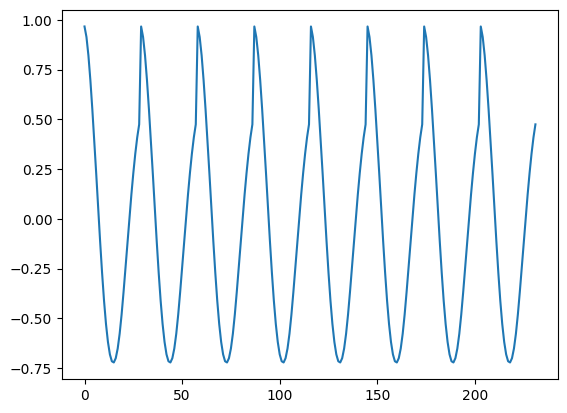

In [22]:
plt.plot(observation[0].detach().numpy()+observation[1].detach().numpy())

In [18]:
summary(model, input_size=[(batch_size, state_dim), (batch_size, input_dim)])

Layer (type:depth-idx)                   Output Shape              Param #
StateSpaceModel                          [10, 1]                   --
├─KAN: 1-1                               [10, 1]                   --
│    └─ModuleList: 2-1                   --                        --
│    │    └─KANLinear: 3-1               [10, 64]                  1,920
│    │    └─KANLinear: 3-2               [10, 64]                  40,960
│    │    └─KANLinear: 3-3               [10, 1]                   640
├─KAN: 1-2                               [10, 1]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─KANLinear: 3-4               [10, 64]                  1,920
│    │    └─KANLinear: 3-5               [10, 64]                  40,960
│    │    └─KANLinear: 3-6               [10, 1]                   640
Total params: 87,040
Trainable params: 87,040
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass si